# Full Training Pipeline Example

Actual code needs to be split to `.py` files for easier deployment on great lakes

## Imports

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import shutil

import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text
from official.nlp import optimization  # to create AdamW optimizer

import matplotlib.pyplot as plt

from train_methods import *

tf.get_logger().setLevel('ERROR')

2023-11-04 22:44:22.726020: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-11-04 22:44:22.901550: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-11-04 22:44:23.727679: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


## Test loading of dataset

In [3]:
train_ds = load_dataset(os.path.join('data','syn_train_small.npz'),
                        text_key='syntheticText', confounder_key='syntheticType',
                        label_key='above3Stars')

train_ds = train_ds.batch(3)
for input, label in train_ds.take(1):
  print('Text:',input['text'])
  print('SynType:',input['confounder'])
  print('Label:',label)

Text: tf.Tensor(
[b'Really comfortable and easy to nurse in.'
 b'Fun for my 9 year old grandson.' b'great little old school watch'], shape=(3,), dtype=string)
SynType: tf.Tensor([0 1 0], shape=(3,), dtype=int64)
Label: tf.Tensor([ True  True  True], shape=(3,), dtype=bool)


2023-11-04 22:44:25.006951: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-11-04 22:44:25.255160: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1960] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


## Test accessing BERT model which have been downloaded previously
- (Preprocessor): https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3
- (BERT encoder): https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/4

In [4]:
dir = 'pretrained_models'
preprocessor_path = 'bert_en_uncased_preprocess_3'
bert_path = 'bert_en_uncased_L-12_H-768_A-12_4'

tfhub_handle_preprocess = hub.load(os.path.join(dir, preprocessor_path))
tfhub_handle_encoder = hub.load(os.path.join(dir, bert_path))

## Load preprocess model

In [5]:
bert_preprocess_model = hub.KerasLayer(tfhub_handle_preprocess, name='preprocessing')

## Test preprocessing lines

In [6]:
for input, _ in train_ds.take(1):
    text_test = input['text']

# text_test = ['this is such an amazing movie!']
text_preprocessed = bert_preprocess_model(text_test)

print(f'Text       : {text_test[0]}') # note we are receiving batch inputs
print(f'Keys       : {list(text_preprocessed.keys())}')
print(f'Shape      : {text_preprocessed["input_word_ids"].shape}')
print(f'Word Ids   : {text_preprocessed["input_word_ids"][0, :12]}')
print(f'Input Mask : {text_preprocessed["input_mask"][0, :12]}')
print(f'Type Ids   : {text_preprocessed["input_type_ids"][0, :12]}')

Text       : b'Really comfortable and easy to nurse in.'
Keys       : ['input_mask', 'input_word_ids', 'input_type_ids']
Shape      : (3, 128)
Word Ids   : [ 101 2428 6625 1998 3733 2000 6821 1999 1012  102    0    0]
Input Mask : [1 1 1 1 1 1 1 1 1 1 0 0]
Type Ids   : [0 0 0 0 0 0 0 0 0 0 0 0]


## Load BERT model

In [7]:
bert_model = hub.KerasLayer(tfhub_handle_encoder, name='BERT_encoder')

## Test BERT working with our preprocessed text

In [8]:
bert_results = bert_model(text_preprocessed)

print(f'Loaded BERT: {tfhub_handle_encoder}')
print(f'Pooled Outputs Shape:{bert_results["pooled_output"].shape}')
print(f'Pooled Outputs Values:{bert_results["pooled_output"][0, :12]}')
print(f'Sequence Outputs Shape:{bert_results["sequence_output"].shape}')
print(f'Sequence Outputs Values:{bert_results["sequence_output"][0, :12]}')

Loaded BERT: <tensorflow.python.saved_model.load.Loader._recreate_base_user_object.<locals>._UserObject object at 0x7fcb523dca30>
Pooled Outputs Shape:(3, 768)
Pooled Outputs Values:[-0.8911018  -0.44995022 -0.96152234  0.888853    0.89250624 -0.2579238
  0.9336112   0.24297626 -0.881901   -0.9999801  -0.73665917  0.9725414 ]
Sequence Outputs Shape:(3, 128, 768)
Sequence Outputs Values:[[-0.5717427  -0.2785303  -0.09064898 ... -0.2163676   0.14871742
   0.5528646 ]
 [-0.11702047 -0.39797044  0.2600247  ... -0.44388756  0.6651581
   0.05599359]
 [-0.00202729 -0.41883603 -0.1955813  ... -0.5208752   1.1054397
  -0.10642844]
 ...
 [ 0.751309    0.11808258 -0.27081656 ...  0.14186983 -0.53353894
  -0.08406344]
 [ 0.0351866   0.00509924  0.1535177  ... -0.1417339  -0.00798567
   0.372732  ]
 [-0.12860431 -0.27192113  0.08692047 ... -0.19333845 -0.18619394
   0.5544615 ]]


## Build augmented model from bert and encoding layers and mmd loss function

Note how we pass in `sample_mmd_loss` as a sample method for adding MMD loss

In [92]:
def sample_mmd_loss(z, y_pred):
    print('z:',z)
    print('y:',y)
    return 10

# store preprocessor and base_model as a model
model = build_augmented_model(bert_preprocess_model, bert_model,
                              sample_mmd_loss) #<--- pass in a trivial loss to not affect gradients (just for demo)

# compile with optimizer, loss and metrics
model.compile(optimizer="adam",
              loss = tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics = tf.metrics.BinaryAccuracy())

# test if it can process inputs
for input, label in train_ds.take(1):
    pred = model.evaluate(input) # <-- note loss of +10.0 from our trivial mmd cost (set mmd_loss to None to remove)
    print('Input: ', input['text'])
    print('Pred_label: ', pred)
    print('Actual_lebl: ', label)

z: Tensor("Placeholder:0", shape=(None,), dtype=bool)
y: tf.Tensor([ True  True  True], shape=(3,), dtype=bool)
z: Tensor("model_36/Cast:0", shape=(None,), dtype=bool)
y: tf.Tensor([ True  True  True], shape=(3,), dtype=bool)
1/1 [==============================] - 0s 283ms/step - loss: 10.0000 - binary_accuracy: 0.0000e+00
Input:  tf.Tensor(
[b'Really comfortable and easy to nurse in.'
 b'Fun for my 9 year old grandson.' b'great little old school watch'], shape=(3,), dtype=string)
Pred_label:  [10.0, 0.0]
Actual_lebl:  tf.Tensor([ True  True  True], shape=(3,), dtype=bool)


## Training of model

In [93]:
epochs = 5

print(f'Training model with {tfhub_handle_encoder}')
history = model.fit(x=train_ds,
                    epochs=epochs)

Training model with <tensorflow.python.saved_model.load.Loader._recreate_base_user_object.<locals>._UserObject object at 0x7f9de62da8f0>
Epoch 1/5


z: Tensor("model_36/Cast:0", shape=(None,), dtype=bool)
y: tf.Tensor([ True  True  True], shape=(3,), dtype=bool)
z: Tensor("model_36/Cast:0", shape=(None,), dtype=bool)
y: tf.Tensor([ True  True  True], shape=(3,), dtype=bool)
97/97 [==============================] - 24s 233ms/step - loss: 10.7086 - binary_accuracy: 0.5241
Epoch 2/5
97/97 [==============================] - 23s 234ms/step - loss: 10.6999 - binary_accuracy: 0.5586
Epoch 3/5
97/97 [==============================] - 23s 232ms/step - loss: 10.6866 - binary_accuracy: 0.5862
Epoch 4/5
97/97 [==============================] - 22s 228ms/step - loss: 10.6557 - binary_accuracy: 0.5724
Epoch 5/5
97/97 [==============================] - 22s 229ms/step - loss: 10.6611 - binary_accuracy: 0.5793


## Simple plot of history (not required for training)

Currently, our training do not have validation, but is pretty straight forward to do so

dict_keys(['loss', 'binary_accuracy'])


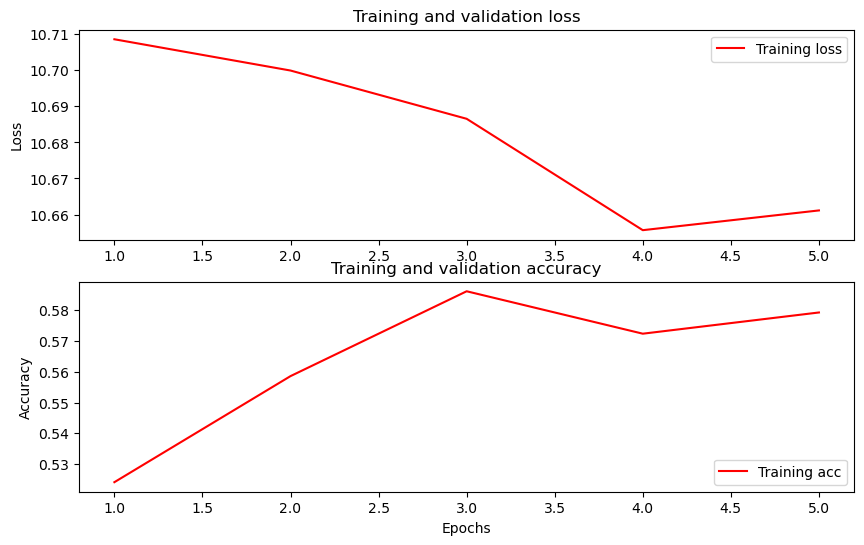

In [95]:
history_dict = history.history
print(history_dict.keys())

acc = history_dict['binary_accuracy']
# val_acc = history_dict['val_binary_accuracy']
loss = history_dict['loss']
# val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)
fig = plt.figure(figsize=(10, 6))
fig.tight_layout()

plt.subplot(2, 1, 1)
# r is for "solid red line"
plt.plot(epochs, loss, 'r', label='Training loss')
# b is for "solid blue line"
# plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
# plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(epochs, acc, 'r', label='Training acc')
# plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

## Saving of model weights
- (To see if saving of entire model is possible, but this seems to be the best for now)

In [98]:
dir = 'trained_model_weights'
file_name = 'BERT_example_weights'

# save model
model.save_weights(os.path.join(dir, file_name))

## Loading trained model weights

In [99]:
# loads model weights from file
model.load_weights(os.path.join(dir, file_name))

# test if it can process inputs
for input, label in train_ds.take(1):
    pred = model(input)
    print('Input: ', input['text'])
    print('Pred_label: ', pred)
    print('Actual_lebl: ', label)

z: tf.Tensor([False  True False], shape=(3,), dtype=bool)
y: tf.Tensor([ True  True  True], shape=(3,), dtype=bool)
Input:  tf.Tensor(
[b'Really comfortable and easy to nurse in.'
 b'Fun for my 9 year old grandson.' b'great little old school watch'], shape=(3,), dtype=string)
Pred_label:  tf.Tensor(
[[0.23889878]
 [0.25808266]
 [0.10581377]], shape=(3, 1), dtype=float32)
Actual_lebl:  tf.Tensor([ True  True  True], shape=(3,), dtype=bool)
